In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt

from utils import mnist
import numpy as np

In [2]:
def plot_train_test(logs, tpe='loss'):
    fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
    for log in logs:
        keys = log.keys()
        logs = {k:[z for z in zip(*log[k])] for k in keys}
        epochs = {k:range(len(log[k])) for k in keys}

        if tpe == 'loss':
            handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
            plt.title('errors')
            plt.xlabel('epoch')
            plt.ylabel('error')

        elif tpe == 'accuracy':
            handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
            plt.title('accuracy')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
    plt.legend(handles=handlers)
    plt.show()

In [3]:
train_loader, test_loader = mnist()

In [4]:
class Net(nn.Module):
    def __init__(self, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
#         self.fc4 = nn.Linear(128, 128)
#         self.fc5 = nn.Linear(64, 64)
#         self.fc6 = nn.Linear(64, 64)
#         self.fc7 = nn.Linear(64, 64)
#         self.fc8 = nn.Linear(64, 64)
        self.fc9 = nn.Linear(128, 10)
        self.optim = optim.SGD(self.parameters(), lr=2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
#         x = torch.sigmoid(self.fc4(x))
#         x = torch.sigmoid(self.fc5(x))
#         x = torch.sigmoid(self.fc6(x))
#         x = torch.sigmoid(self.fc7(x))
#         x = torch.sigmoid(self.fc8(x))
        x = self.fc9(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def train(epoch, models, log=None):
#     train_size = len(train_loader.sampler)
    train_size = 6000
    train_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    limit = train_size / 600
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx == limit:
            break
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            train_loss[k] += loss.item() # sum up batch loss
            loss.backward()
            model.optim.step()
            pred = output.data.max(1, keepdim=True)[1]
            correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        if batch_idx % 2 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
    for k in models:
        train_loss[k] /= train_size
    correct_pct = {k: 100. * correct[k] / train_size for k in correct}
    if log is not None:
        for k in models:
            log[k].append((train_loss[k], correct_pct[k]))

In [6]:
models = {'default': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def test(models, loader, log=None):
#     test_size = len(loader.sampler)
    test_size = 1800
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        limit = test_size / 600
        kl = 0
        for data, target in loader:
            kl+=1  
            if kl == limit:
                break
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [8]:
for epoch in range(1, 1001):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [0/6000 (0%)]	Losses default: 2.326850
Train Epoch: 1 [1200/6000 (0%)]	Losses default: 5.496267
Train Epoch: 1 [2400/6000 (0%)]	Losses default: 2.473640
Train Epoch: 1 [3600/6000 (0%)]	Losses default: 2.343104
Train Epoch: 1 [4800/6000 (0%)]	Losses default: 2.312197
Test set:
default: Loss: 1.5335	Accuracy: 148.0/1800 (8%)

Train Epoch: 2 [0/6000 (0%)]	Losses default: 2.297748
Train Epoch: 2 [1200/6000 (0%)]	Losses default: 2.298057
Train Epoch: 2 [2400/6000 (0%)]	Losses default: 2.299610
Train Epoch: 2 [3600/6000 (0%)]	Losses default: 2.295215
Train Epoch: 2 [4800/6000 (0%)]	Losses default: 2.290922
Test set:
default: Loss: 1.5283	Accuracy: 148.0/1800 (8%)

Train Epoch: 3 [0/6000 (0%)]	Losses default: 2.296515
Train Epoch: 3 [1200/6000 (0%)]	Losses default: 2.292813
Train Epoch: 3 [2400/6000 (0%)]	Losses default: 2.293019
Train Epoch: 3 [3600/6000 (0%)]	Losses default: 2.292581
Train Epoch: 3 [4800/6000 (0%)]	Losses default: 2.294417
Test set:
default: Loss: 1.5257	Accu

Test set:
default: Loss: 0.9687	Accuracy: 479.0/1800 (27%)

Train Epoch: 25 [0/6000 (0%)]	Losses default: 1.403879
Train Epoch: 25 [1200/6000 (0%)]	Losses default: 1.318028
Train Epoch: 25 [2400/6000 (0%)]	Losses default: 1.277405
Train Epoch: 25 [3600/6000 (0%)]	Losses default: 1.253742
Train Epoch: 25 [4800/6000 (0%)]	Losses default: 1.498585
Test set:
default: Loss: 0.8992	Accuracy: 502.0/1800 (28%)

Train Epoch: 26 [0/6000 (0%)]	Losses default: 1.336553
Train Epoch: 26 [1200/6000 (0%)]	Losses default: 1.245050
Train Epoch: 26 [2400/6000 (0%)]	Losses default: 1.187103
Train Epoch: 26 [3600/6000 (0%)]	Losses default: 1.174911
Train Epoch: 26 [4800/6000 (0%)]	Losses default: 1.185943
Test set:
default: Loss: 0.7733	Accuracy: 666.0/1800 (37%)

Train Epoch: 27 [0/6000 (0%)]	Losses default: 1.199811
Train Epoch: 27 [1200/6000 (0%)]	Losses default: 1.154041
Train Epoch: 27 [2400/6000 (0%)]	Losses default: 1.257678
Train Epoch: 27 [3600/6000 (0%)]	Losses default: 1.134047
Train Epoch: 27 [

Train Epoch: 48 [2400/6000 (0%)]	Losses default: 0.407341
Train Epoch: 48 [3600/6000 (0%)]	Losses default: 0.369572
Train Epoch: 48 [4800/6000 (0%)]	Losses default: 0.322840
Test set:
default: Loss: 0.2381	Accuracy: 1075.0/1800 (60%)

Train Epoch: 49 [0/6000 (0%)]	Losses default: 0.312668
Train Epoch: 49 [1200/6000 (0%)]	Losses default: 0.324998
Train Epoch: 49 [2400/6000 (0%)]	Losses default: 0.336481
Train Epoch: 49 [3600/6000 (0%)]	Losses default: 0.364905
Train Epoch: 49 [4800/6000 (0%)]	Losses default: 0.588648
Test set:
default: Loss: 0.8080	Accuracy: 782.0/1800 (43%)

Train Epoch: 50 [0/6000 (0%)]	Losses default: 1.212216
Train Epoch: 50 [1200/6000 (0%)]	Losses default: 0.445252
Train Epoch: 50 [2400/6000 (0%)]	Losses default: 0.388727
Train Epoch: 50 [3600/6000 (0%)]	Losses default: 0.376437
Train Epoch: 50 [4800/6000 (0%)]	Losses default: 0.338383
Test set:
default: Loss: 0.2485	Accuracy: 1069.0/1800 (59%)

Train Epoch: 51 [0/6000 (0%)]	Losses default: 0.276098
Train Epoch: 51

Train Epoch: 72 [1200/6000 (0%)]	Losses default: 0.198739
Train Epoch: 72 [2400/6000 (0%)]	Losses default: 0.155132
Train Epoch: 72 [3600/6000 (0%)]	Losses default: 0.173830
Train Epoch: 72 [4800/6000 (0%)]	Losses default: 0.117322
Test set:
default: Loss: 0.1113	Accuracy: 1141.0/1800 (63%)

Train Epoch: 73 [0/6000 (0%)]	Losses default: 0.117345
Train Epoch: 73 [1200/6000 (0%)]	Losses default: 0.119253
Train Epoch: 73 [2400/6000 (0%)]	Losses default: 0.180982
Train Epoch: 73 [3600/6000 (0%)]	Losses default: 0.115808
Train Epoch: 73 [4800/6000 (0%)]	Losses default: 0.138086
Test set:
default: Loss: 0.1063	Accuracy: 1144.0/1800 (64%)

Train Epoch: 74 [0/6000 (0%)]	Losses default: 0.228093
Train Epoch: 74 [1200/6000 (0%)]	Losses default: 0.204760
Train Epoch: 74 [2400/6000 (0%)]	Losses default: 0.163320
Train Epoch: 74 [3600/6000 (0%)]	Losses default: 0.141971
Train Epoch: 74 [4800/6000 (0%)]	Losses default: 0.114765
Test set:
default: Loss: 0.1043	Accuracy: 1141.0/1800 (63%)

Train Epoch

Train Epoch: 95 [4800/6000 (0%)]	Losses default: 0.139687
Test set:
default: Loss: 0.0940	Accuracy: 1147.0/1800 (64%)

Train Epoch: 96 [0/6000 (0%)]	Losses default: 0.109102
Train Epoch: 96 [1200/6000 (0%)]	Losses default: 0.101571
Train Epoch: 96 [2400/6000 (0%)]	Losses default: 0.089886
Train Epoch: 96 [3600/6000 (0%)]	Losses default: 0.109698
Train Epoch: 96 [4800/6000 (0%)]	Losses default: 0.119143
Test set:
default: Loss: 0.0847	Accuracy: 1156.0/1800 (64%)

Train Epoch: 97 [0/6000 (0%)]	Losses default: 0.093065
Train Epoch: 97 [1200/6000 (0%)]	Losses default: 0.124918
Train Epoch: 97 [2400/6000 (0%)]	Losses default: 0.094721
Train Epoch: 97 [3600/6000 (0%)]	Losses default: 0.086927
Train Epoch: 97 [4800/6000 (0%)]	Losses default: 0.120006
Test set:
default: Loss: 0.1069	Accuracy: 1143.0/1800 (64%)

Train Epoch: 98 [0/6000 (0%)]	Losses default: 0.143899
Train Epoch: 98 [1200/6000 (0%)]	Losses default: 0.105407
Train Epoch: 98 [2400/6000 (0%)]	Losses default: 0.087114
Train Epoch: 9

Train Epoch: 119 [1200/6000 (0%)]	Losses default: 0.096716
Train Epoch: 119 [2400/6000 (0%)]	Losses default: 0.077064
Train Epoch: 119 [3600/6000 (0%)]	Losses default: 0.085410
Train Epoch: 119 [4800/6000 (0%)]	Losses default: 0.071163
Test set:
default: Loss: 0.0768	Accuracy: 1158.0/1800 (64%)

Train Epoch: 120 [0/6000 (0%)]	Losses default: 0.068916
Train Epoch: 120 [1200/6000 (0%)]	Losses default: 0.068818
Train Epoch: 120 [2400/6000 (0%)]	Losses default: 0.107115
Train Epoch: 120 [3600/6000 (0%)]	Losses default: 0.095773
Train Epoch: 120 [4800/6000 (0%)]	Losses default: 0.098367
Test set:
default: Loss: 0.0769	Accuracy: 1162.0/1800 (65%)

Train Epoch: 121 [0/6000 (0%)]	Losses default: 0.086320
Train Epoch: 121 [1200/6000 (0%)]	Losses default: 0.079642
Train Epoch: 121 [2400/6000 (0%)]	Losses default: 0.064304
Train Epoch: 121 [3600/6000 (0%)]	Losses default: 0.094979
Train Epoch: 121 [4800/6000 (0%)]	Losses default: 0.062206
Test set:
default: Loss: 0.0776	Accuracy: 1166.0/1800 (65%

Train Epoch: 142 [2400/6000 (0%)]	Losses default: 0.042411
Train Epoch: 142 [3600/6000 (0%)]	Losses default: 0.074738
Train Epoch: 142 [4800/6000 (0%)]	Losses default: 0.058014
Test set:
default: Loss: 0.0645	Accuracy: 1169.0/1800 (65%)

Train Epoch: 143 [0/6000 (0%)]	Losses default: 0.045985
Train Epoch: 143 [1200/6000 (0%)]	Losses default: 0.090566
Train Epoch: 143 [2400/6000 (0%)]	Losses default: 0.054281
Train Epoch: 143 [3600/6000 (0%)]	Losses default: 0.070206
Train Epoch: 143 [4800/6000 (0%)]	Losses default: 0.079218
Test set:
default: Loss: 0.0685	Accuracy: 1165.0/1800 (65%)

Train Epoch: 144 [0/6000 (0%)]	Losses default: 0.036127
Train Epoch: 144 [1200/6000 (0%)]	Losses default: 0.046062
Train Epoch: 144 [2400/6000 (0%)]	Losses default: 0.044054
Train Epoch: 144 [3600/6000 (0%)]	Losses default: 0.040734
Train Epoch: 144 [4800/6000 (0%)]	Losses default: 0.070905
Test set:
default: Loss: 0.0745	Accuracy: 1162.0/1800 (65%)

Train Epoch: 145 [0/6000 (0%)]	Losses default: 0.075840


Train Epoch: 165 [4800/6000 (0%)]	Losses default: 1.306647
Test set:
default: Loss: 1.5250	Accuracy: 721.0/1800 (40%)

Train Epoch: 166 [0/6000 (0%)]	Losses default: 2.540886
Train Epoch: 166 [1200/6000 (0%)]	Losses default: 0.474806
Train Epoch: 166 [2400/6000 (0%)]	Losses default: 0.218893
Train Epoch: 166 [3600/6000 (0%)]	Losses default: 0.092798
Train Epoch: 166 [4800/6000 (0%)]	Losses default: 0.094941
Test set:
default: Loss: 0.0912	Accuracy: 1150.0/1800 (64%)

Train Epoch: 167 [0/6000 (0%)]	Losses default: 0.112944
Train Epoch: 167 [1200/6000 (0%)]	Losses default: 0.093961
Train Epoch: 167 [2400/6000 (0%)]	Losses default: 0.082693
Train Epoch: 167 [3600/6000 (0%)]	Losses default: 0.038046
Train Epoch: 167 [4800/6000 (0%)]	Losses default: 0.070464
Test set:
default: Loss: 0.0815	Accuracy: 1160.0/1800 (64%)

Train Epoch: 168 [0/6000 (0%)]	Losses default: 0.048384
Train Epoch: 168 [1200/6000 (0%)]	Losses default: 0.055967
Train Epoch: 168 [2400/6000 (0%)]	Losses default: 0.052832
T

Train Epoch: 189 [1200/6000 (0%)]	Losses default: 0.046999
Train Epoch: 189 [2400/6000 (0%)]	Losses default: 0.020958
Train Epoch: 189 [3600/6000 (0%)]	Losses default: 0.023230
Train Epoch: 189 [4800/6000 (0%)]	Losses default: 0.026900
Test set:
default: Loss: 0.0666	Accuracy: 1166.0/1800 (65%)

Train Epoch: 190 [0/6000 (0%)]	Losses default: 0.023640
Train Epoch: 190 [1200/6000 (0%)]	Losses default: 0.036591
Train Epoch: 190 [2400/6000 (0%)]	Losses default: 0.038480
Train Epoch: 190 [3600/6000 (0%)]	Losses default: 0.041847
Train Epoch: 190 [4800/6000 (0%)]	Losses default: 0.025029
Test set:
default: Loss: 0.0678	Accuracy: 1167.0/1800 (65%)

Train Epoch: 191 [0/6000 (0%)]	Losses default: 0.023502
Train Epoch: 191 [1200/6000 (0%)]	Losses default: 0.020961
Train Epoch: 191 [2400/6000 (0%)]	Losses default: 0.039432
Train Epoch: 191 [3600/6000 (0%)]	Losses default: 0.037237
Train Epoch: 191 [4800/6000 (0%)]	Losses default: 0.032590
Test set:
default: Loss: 0.0667	Accuracy: 1168.0/1800 (65%

Train Epoch: 212 [3600/6000 (0%)]	Losses default: 0.030132
Train Epoch: 212 [4800/6000 (0%)]	Losses default: 0.062208
Test set:
default: Loss: 0.0659	Accuracy: 1170.0/1800 (65%)

Train Epoch: 213 [0/6000 (0%)]	Losses default: 0.026893
Train Epoch: 213 [1200/6000 (0%)]	Losses default: 0.044381
Train Epoch: 213 [2400/6000 (0%)]	Losses default: 0.023169
Train Epoch: 213 [3600/6000 (0%)]	Losses default: 0.018253
Train Epoch: 213 [4800/6000 (0%)]	Losses default: 0.016241
Test set:
default: Loss: 0.0642	Accuracy: 1166.0/1800 (65%)

Train Epoch: 214 [0/6000 (0%)]	Losses default: 0.031262
Train Epoch: 214 [1200/6000 (0%)]	Losses default: 0.035362
Train Epoch: 214 [2400/6000 (0%)]	Losses default: 0.041870
Train Epoch: 214 [3600/6000 (0%)]	Losses default: 0.010659
Train Epoch: 214 [4800/6000 (0%)]	Losses default: 0.031045
Test set:
default: Loss: 0.0620	Accuracy: 1166.0/1800 (65%)

Train Epoch: 215 [0/6000 (0%)]	Losses default: 0.032858
Train Epoch: 215 [1200/6000 (0%)]	Losses default: 0.025525


Test set:
default: Loss: 0.0648	Accuracy: 1168.0/1800 (65%)

Train Epoch: 236 [0/6000 (0%)]	Losses default: 0.016712
Train Epoch: 236 [1200/6000 (0%)]	Losses default: 0.014416
Train Epoch: 236 [2400/6000 (0%)]	Losses default: 0.017684
Train Epoch: 236 [3600/6000 (0%)]	Losses default: 0.010550
Train Epoch: 236 [4800/6000 (0%)]	Losses default: 0.008100
Test set:
default: Loss: 0.0672	Accuracy: 1165.0/1800 (65%)

Train Epoch: 237 [0/6000 (0%)]	Losses default: 0.033664
Train Epoch: 237 [1200/6000 (0%)]	Losses default: 0.010914
Train Epoch: 237 [2400/6000 (0%)]	Losses default: 0.009155
Train Epoch: 237 [3600/6000 (0%)]	Losses default: 0.019261
Train Epoch: 237 [4800/6000 (0%)]	Losses default: 0.016324
Test set:
default: Loss: 0.0686	Accuracy: 1160.0/1800 (64%)

Train Epoch: 238 [0/6000 (0%)]	Losses default: 0.019358
Train Epoch: 238 [1200/6000 (0%)]	Losses default: 0.011676
Train Epoch: 238 [2400/6000 (0%)]	Losses default: 0.014570
Train Epoch: 238 [3600/6000 (0%)]	Losses default: 0.019083


Train Epoch: 259 [1200/6000 (0%)]	Losses default: 0.014154
Train Epoch: 259 [2400/6000 (0%)]	Losses default: 0.005981
Train Epoch: 259 [3600/6000 (0%)]	Losses default: 0.008910
Train Epoch: 259 [4800/6000 (0%)]	Losses default: 0.016191
Test set:
default: Loss: 0.0645	Accuracy: 1170.0/1800 (65%)

Train Epoch: 260 [0/6000 (0%)]	Losses default: 0.012811
Train Epoch: 260 [1200/6000 (0%)]	Losses default: 0.010101
Train Epoch: 260 [2400/6000 (0%)]	Losses default: 0.008118
Train Epoch: 260 [3600/6000 (0%)]	Losses default: 0.005805
Train Epoch: 260 [4800/6000 (0%)]	Losses default: 0.011910
Test set:
default: Loss: 0.0621	Accuracy: 1171.0/1800 (65%)

Train Epoch: 261 [0/6000 (0%)]	Losses default: 0.010134
Train Epoch: 261 [1200/6000 (0%)]	Losses default: 0.010999
Train Epoch: 261 [2400/6000 (0%)]	Losses default: 0.012781
Train Epoch: 261 [3600/6000 (0%)]	Losses default: 0.010679
Train Epoch: 261 [4800/6000 (0%)]	Losses default: 0.012381
Test set:
default: Loss: 0.0627	Accuracy: 1170.0/1800 (65%

Train Epoch: 282 [3600/6000 (0%)]	Losses default: 0.026545
Train Epoch: 282 [4800/6000 (0%)]	Losses default: 0.008360
Test set:
default: Loss: 0.0686	Accuracy: 1164.0/1800 (65%)

Train Epoch: 283 [0/6000 (0%)]	Losses default: 0.009146
Train Epoch: 283 [1200/6000 (0%)]	Losses default: 0.009482
Train Epoch: 283 [2400/6000 (0%)]	Losses default: 0.006672
Train Epoch: 283 [3600/6000 (0%)]	Losses default: 0.007037
Train Epoch: 283 [4800/6000 (0%)]	Losses default: 0.012977
Test set:
default: Loss: 0.0715	Accuracy: 1165.0/1800 (65%)

Train Epoch: 284 [0/6000 (0%)]	Losses default: 0.013444
Train Epoch: 284 [1200/6000 (0%)]	Losses default: 0.009411
Train Epoch: 284 [2400/6000 (0%)]	Losses default: 0.005284
Train Epoch: 284 [3600/6000 (0%)]	Losses default: 0.010056
Train Epoch: 284 [4800/6000 (0%)]	Losses default: 0.010380
Test set:
default: Loss: 0.0727	Accuracy: 1164.0/1800 (65%)

Train Epoch: 285 [0/6000 (0%)]	Losses default: 0.005624
Train Epoch: 285 [1200/6000 (0%)]	Losses default: 0.011184


Test set:
default: Loss: 0.0670	Accuracy: 1169.0/1800 (65%)

Train Epoch: 306 [0/6000 (0%)]	Losses default: 0.007744
Train Epoch: 306 [1200/6000 (0%)]	Losses default: 0.005697
Train Epoch: 306 [2400/6000 (0%)]	Losses default: 0.009904
Train Epoch: 306 [3600/6000 (0%)]	Losses default: 0.009493
Train Epoch: 306 [4800/6000 (0%)]	Losses default: 0.006392
Test set:
default: Loss: 0.0694	Accuracy: 1167.0/1800 (65%)

Train Epoch: 307 [0/6000 (0%)]	Losses default: 0.006263
Train Epoch: 307 [1200/6000 (0%)]	Losses default: 0.006470
Train Epoch: 307 [2400/6000 (0%)]	Losses default: 0.010537
Train Epoch: 307 [3600/6000 (0%)]	Losses default: 0.012510
Train Epoch: 307 [4800/6000 (0%)]	Losses default: 0.005379
Test set:
default: Loss: 0.0696	Accuracy: 1166.0/1800 (65%)

Train Epoch: 308 [0/6000 (0%)]	Losses default: 0.008769
Train Epoch: 308 [1200/6000 (0%)]	Losses default: 0.004697
Train Epoch: 308 [2400/6000 (0%)]	Losses default: 0.010492
Train Epoch: 308 [3600/6000 (0%)]	Losses default: 0.006889


Train Epoch: 329 [1200/6000 (0%)]	Losses default: 0.005811
Train Epoch: 329 [2400/6000 (0%)]	Losses default: 0.010226
Train Epoch: 329 [3600/6000 (0%)]	Losses default: 0.004945
Train Epoch: 329 [4800/6000 (0%)]	Losses default: 0.009536
Test set:
default: Loss: 0.0680	Accuracy: 1167.0/1800 (65%)

Train Epoch: 330 [0/6000 (0%)]	Losses default: 0.004071
Train Epoch: 330 [1200/6000 (0%)]	Losses default: 0.006603
Train Epoch: 330 [2400/6000 (0%)]	Losses default: 0.004481
Train Epoch: 330 [3600/6000 (0%)]	Losses default: 0.004018
Train Epoch: 330 [4800/6000 (0%)]	Losses default: 0.007561
Test set:
default: Loss: 0.0714	Accuracy: 1165.0/1800 (65%)

Train Epoch: 331 [0/6000 (0%)]	Losses default: 0.006307
Train Epoch: 331 [1200/6000 (0%)]	Losses default: 0.005903
Train Epoch: 331 [2400/6000 (0%)]	Losses default: 0.022669
Train Epoch: 331 [3600/6000 (0%)]	Losses default: 0.002812
Train Epoch: 331 [4800/6000 (0%)]	Losses default: 0.003653
Test set:
default: Loss: 0.0706	Accuracy: 1167.0/1800 (65%

Train Epoch: 352 [2400/6000 (0%)]	Losses default: 0.002770
Train Epoch: 352 [3600/6000 (0%)]	Losses default: 0.005141
Train Epoch: 352 [4800/6000 (0%)]	Losses default: 0.006816
Test set:
default: Loss: 0.0729	Accuracy: 1161.0/1800 (64%)

Train Epoch: 353 [0/6000 (0%)]	Losses default: 0.005341
Train Epoch: 353 [1200/6000 (0%)]	Losses default: 0.009649
Train Epoch: 353 [2400/6000 (0%)]	Losses default: 0.004512
Train Epoch: 353 [3600/6000 (0%)]	Losses default: 0.002709
Train Epoch: 353 [4800/6000 (0%)]	Losses default: 0.002658
Test set:
default: Loss: 0.0683	Accuracy: 1168.0/1800 (65%)

Train Epoch: 354 [0/6000 (0%)]	Losses default: 0.005019
Train Epoch: 354 [1200/6000 (0%)]	Losses default: 0.003141
Train Epoch: 354 [2400/6000 (0%)]	Losses default: 0.005671
Train Epoch: 354 [3600/6000 (0%)]	Losses default: 0.003674
Train Epoch: 354 [4800/6000 (0%)]	Losses default: 0.003410
Test set:
default: Loss: 0.0700	Accuracy: 1166.0/1800 (65%)

Train Epoch: 355 [0/6000 (0%)]	Losses default: 0.002498


Train Epoch: 375 [3600/6000 (0%)]	Losses default: 0.003482
Train Epoch: 375 [4800/6000 (0%)]	Losses default: 0.002086
Test set:
default: Loss: 0.0709	Accuracy: 1165.0/1800 (65%)

Train Epoch: 376 [0/6000 (0%)]	Losses default: 0.003787
Train Epoch: 376 [1200/6000 (0%)]	Losses default: 0.003983
Train Epoch: 376 [2400/6000 (0%)]	Losses default: 0.001826
Train Epoch: 376 [3600/6000 (0%)]	Losses default: 0.003567
Train Epoch: 376 [4800/6000 (0%)]	Losses default: 0.004353
Test set:
default: Loss: 0.0702	Accuracy: 1167.0/1800 (65%)

Train Epoch: 377 [0/6000 (0%)]	Losses default: 0.002639
Train Epoch: 377 [1200/6000 (0%)]	Losses default: 0.005596
Train Epoch: 377 [2400/6000 (0%)]	Losses default: 0.002705
Train Epoch: 377 [3600/6000 (0%)]	Losses default: 0.003946
Train Epoch: 377 [4800/6000 (0%)]	Losses default: 0.002667
Test set:
default: Loss: 0.0702	Accuracy: 1170.0/1800 (65%)

Train Epoch: 378 [0/6000 (0%)]	Losses default: 0.005655
Train Epoch: 378 [1200/6000 (0%)]	Losses default: 0.003072


Train Epoch: 398 [4800/6000 (0%)]	Losses default: 0.004030
Test set:
default: Loss: 0.0703	Accuracy: 1168.0/1800 (65%)

Train Epoch: 399 [0/6000 (0%)]	Losses default: 0.006295
Train Epoch: 399 [1200/6000 (0%)]	Losses default: 0.004089
Train Epoch: 399 [2400/6000 (0%)]	Losses default: 0.003950
Train Epoch: 399 [3600/6000 (0%)]	Losses default: 0.002187
Train Epoch: 399 [4800/6000 (0%)]	Losses default: 0.002511
Test set:
default: Loss: 0.0726	Accuracy: 1167.0/1800 (65%)

Train Epoch: 400 [0/6000 (0%)]	Losses default: 0.002419
Train Epoch: 400 [1200/6000 (0%)]	Losses default: 0.002300
Train Epoch: 400 [2400/6000 (0%)]	Losses default: 0.002705
Train Epoch: 400 [3600/6000 (0%)]	Losses default: 0.002386
Train Epoch: 400 [4800/6000 (0%)]	Losses default: 0.002933
Test set:
default: Loss: 0.0727	Accuracy: 1169.0/1800 (65%)

Train Epoch: 401 [0/6000 (0%)]	Losses default: 0.025919
Train Epoch: 401 [1200/6000 (0%)]	Losses default: 0.002317
Train Epoch: 401 [2400/6000 (0%)]	Losses default: 0.002536


Train Epoch: 422 [1200/6000 (0%)]	Losses default: 0.007884
Train Epoch: 422 [2400/6000 (0%)]	Losses default: 0.001401
Train Epoch: 422 [3600/6000 (0%)]	Losses default: 0.002020
Train Epoch: 422 [4800/6000 (0%)]	Losses default: 0.002435
Test set:
default: Loss: 0.0719	Accuracy: 1167.0/1800 (65%)

Train Epoch: 423 [0/6000 (0%)]	Losses default: 0.003240
Train Epoch: 423 [1200/6000 (0%)]	Losses default: 0.002115
Train Epoch: 423 [2400/6000 (0%)]	Losses default: 0.020540
Train Epoch: 423 [3600/6000 (0%)]	Losses default: 0.001647
Train Epoch: 423 [4800/6000 (0%)]	Losses default: 0.010208
Test set:
default: Loss: 0.0727	Accuracy: 1165.0/1800 (65%)

Train Epoch: 424 [0/6000 (0%)]	Losses default: 0.002093
Train Epoch: 424 [1200/6000 (0%)]	Losses default: 0.003655
Train Epoch: 424 [2400/6000 (0%)]	Losses default: 0.002085
Train Epoch: 424 [3600/6000 (0%)]	Losses default: 0.002170
Train Epoch: 424 [4800/6000 (0%)]	Losses default: 0.002528
Test set:
default: Loss: 0.0716	Accuracy: 1165.0/1800 (65%

Train Epoch: 445 [3600/6000 (0%)]	Losses default: 0.018719
Train Epoch: 445 [4800/6000 (0%)]	Losses default: 0.002158
Test set:
default: Loss: 0.0716	Accuracy: 1168.0/1800 (65%)

Train Epoch: 446 [0/6000 (0%)]	Losses default: 0.002426
Train Epoch: 446 [1200/6000 (0%)]	Losses default: 0.003937
Train Epoch: 446 [2400/6000 (0%)]	Losses default: 0.002185
Train Epoch: 446 [3600/6000 (0%)]	Losses default: 0.002794
Train Epoch: 446 [4800/6000 (0%)]	Losses default: 0.002423
Test set:
default: Loss: 0.0717	Accuracy: 1168.0/1800 (65%)

Train Epoch: 447 [0/6000 (0%)]	Losses default: 0.002481
Train Epoch: 447 [1200/6000 (0%)]	Losses default: 0.002902
Train Epoch: 447 [2400/6000 (0%)]	Losses default: 0.001836
Train Epoch: 447 [3600/6000 (0%)]	Losses default: 0.001949
Train Epoch: 447 [4800/6000 (0%)]	Losses default: 0.001675
Test set:
default: Loss: 0.0715	Accuracy: 1167.0/1800 (65%)

Train Epoch: 448 [0/6000 (0%)]	Losses default: 0.002010
Train Epoch: 448 [1200/6000 (0%)]	Losses default: 0.002206


Train Epoch: 468 [4800/6000 (0%)]	Losses default: 0.002569
Test set:
default: Loss: 0.0716	Accuracy: 1166.0/1800 (65%)

Train Epoch: 469 [0/6000 (0%)]	Losses default: 0.001644
Train Epoch: 469 [1200/6000 (0%)]	Losses default: 0.001869
Train Epoch: 469 [2400/6000 (0%)]	Losses default: 0.002016
Train Epoch: 469 [3600/6000 (0%)]	Losses default: 0.002733
Train Epoch: 469 [4800/6000 (0%)]	Losses default: 0.002891
Test set:
default: Loss: 0.0719	Accuracy: 1167.0/1800 (65%)

Train Epoch: 470 [0/6000 (0%)]	Losses default: 0.001788
Train Epoch: 470 [1200/6000 (0%)]	Losses default: 0.002691
Train Epoch: 470 [2400/6000 (0%)]	Losses default: 0.001756
Train Epoch: 470 [3600/6000 (0%)]	Losses default: 0.001909
Train Epoch: 470 [4800/6000 (0%)]	Losses default: 0.010099
Test set:
default: Loss: 0.0724	Accuracy: 1164.0/1800 (65%)

Train Epoch: 471 [0/6000 (0%)]	Losses default: 0.002454
Train Epoch: 471 [1200/6000 (0%)]	Losses default: 0.001485
Train Epoch: 471 [2400/6000 (0%)]	Losses default: 0.002098


Train Epoch: 492 [1200/6000 (0%)]	Losses default: 0.001643
Train Epoch: 492 [2400/6000 (0%)]	Losses default: 0.001560
Train Epoch: 492 [3600/6000 (0%)]	Losses default: 0.003050
Train Epoch: 492 [4800/6000 (0%)]	Losses default: 0.002331
Test set:
default: Loss: 0.0708	Accuracy: 1169.0/1800 (65%)

Train Epoch: 493 [0/6000 (0%)]	Losses default: 0.002127
Train Epoch: 493 [1200/6000 (0%)]	Losses default: 0.001516
Train Epoch: 493 [2400/6000 (0%)]	Losses default: 0.001428
Train Epoch: 493 [3600/6000 (0%)]	Losses default: 0.002910
Train Epoch: 493 [4800/6000 (0%)]	Losses default: 0.001719
Test set:
default: Loss: 0.0711	Accuracy: 1167.0/1800 (65%)

Train Epoch: 494 [0/6000 (0%)]	Losses default: 0.001510
Train Epoch: 494 [1200/6000 (0%)]	Losses default: 0.001906
Train Epoch: 494 [2400/6000 (0%)]	Losses default: 0.000967
Train Epoch: 494 [3600/6000 (0%)]	Losses default: 0.001370
Train Epoch: 494 [4800/6000 (0%)]	Losses default: 0.001934
Test set:
default: Loss: 0.0712	Accuracy: 1165.0/1800 (65%

Train Epoch: 515 [2400/6000 (0%)]	Losses default: 0.004496
Train Epoch: 515 [3600/6000 (0%)]	Losses default: 0.001247
Train Epoch: 515 [4800/6000 (0%)]	Losses default: 0.001533
Test set:
default: Loss: 0.0741	Accuracy: 1165.0/1800 (65%)

Train Epoch: 516 [0/6000 (0%)]	Losses default: 0.001936
Train Epoch: 516 [1200/6000 (0%)]	Losses default: 0.002204
Train Epoch: 516 [2400/6000 (0%)]	Losses default: 0.001381
Train Epoch: 516 [3600/6000 (0%)]	Losses default: 0.001451
Train Epoch: 516 [4800/6000 (0%)]	Losses default: 0.001976
Test set:
default: Loss: 0.0721	Accuracy: 1168.0/1800 (65%)

Train Epoch: 517 [0/6000 (0%)]	Losses default: 0.006133
Train Epoch: 517 [1200/6000 (0%)]	Losses default: 0.001706
Train Epoch: 517 [2400/6000 (0%)]	Losses default: 0.001361
Train Epoch: 517 [3600/6000 (0%)]	Losses default: 0.001768
Train Epoch: 517 [4800/6000 (0%)]	Losses default: 0.001492
Test set:
default: Loss: 0.0730	Accuracy: 1168.0/1800 (65%)

Train Epoch: 518 [0/6000 (0%)]	Losses default: 0.001552


Train Epoch: 538 [3600/6000 (0%)]	Losses default: 0.001885
Train Epoch: 538 [4800/6000 (0%)]	Losses default: 0.001726
Test set:
default: Loss: 0.0718	Accuracy: 1168.0/1800 (65%)

Train Epoch: 539 [0/6000 (0%)]	Losses default: 0.001711
Train Epoch: 539 [1200/6000 (0%)]	Losses default: 0.001766
Train Epoch: 539 [2400/6000 (0%)]	Losses default: 0.001795
Train Epoch: 539 [3600/6000 (0%)]	Losses default: 0.001076
Train Epoch: 539 [4800/6000 (0%)]	Losses default: 0.001217
Test set:
default: Loss: 0.0719	Accuracy: 1168.0/1800 (65%)

Train Epoch: 540 [0/6000 (0%)]	Losses default: 0.000974
Train Epoch: 540 [1200/6000 (0%)]	Losses default: 0.001433
Train Epoch: 540 [2400/6000 (0%)]	Losses default: 0.001575
Train Epoch: 540 [3600/6000 (0%)]	Losses default: 0.001538
Train Epoch: 540 [4800/6000 (0%)]	Losses default: 0.001307
Test set:
default: Loss: 0.0718	Accuracy: 1169.0/1800 (65%)

Train Epoch: 541 [0/6000 (0%)]	Losses default: 0.001085
Train Epoch: 541 [1200/6000 (0%)]	Losses default: 0.001175


Test set:
default: Loss: 0.0754	Accuracy: 1167.0/1800 (65%)

Train Epoch: 562 [0/6000 (0%)]	Losses default: 0.001644
Train Epoch: 562 [1200/6000 (0%)]	Losses default: 0.001326
Train Epoch: 562 [2400/6000 (0%)]	Losses default: 0.001071
Train Epoch: 562 [3600/6000 (0%)]	Losses default: 0.001905
Train Epoch: 562 [4800/6000 (0%)]	Losses default: 0.001903
Test set:
default: Loss: 0.0737	Accuracy: 1168.0/1800 (65%)

Train Epoch: 563 [0/6000 (0%)]	Losses default: 0.000884
Train Epoch: 563 [1200/6000 (0%)]	Losses default: 0.001197
Train Epoch: 563 [2400/6000 (0%)]	Losses default: 0.001190
Train Epoch: 563 [3600/6000 (0%)]	Losses default: 0.003555
Train Epoch: 563 [4800/6000 (0%)]	Losses default: 0.001194
Test set:
default: Loss: 0.0723	Accuracy: 1169.0/1800 (65%)

Train Epoch: 564 [0/6000 (0%)]	Losses default: 0.001584
Train Epoch: 564 [1200/6000 (0%)]	Losses default: 0.001822
Train Epoch: 564 [2400/6000 (0%)]	Losses default: 0.001306
Train Epoch: 564 [3600/6000 (0%)]	Losses default: 0.001173


Train Epoch: 585 [1200/6000 (0%)]	Losses default: 0.001398
Train Epoch: 585 [2400/6000 (0%)]	Losses default: 0.002971
Train Epoch: 585 [3600/6000 (0%)]	Losses default: 0.000961
Train Epoch: 585 [4800/6000 (0%)]	Losses default: 0.001274
Test set:
default: Loss: 0.0736	Accuracy: 1169.0/1800 (65%)

Train Epoch: 586 [0/6000 (0%)]	Losses default: 0.000953
Train Epoch: 586 [1200/6000 (0%)]	Losses default: 0.001124
Train Epoch: 586 [2400/6000 (0%)]	Losses default: 0.001285
Train Epoch: 586 [3600/6000 (0%)]	Losses default: 0.001275
Train Epoch: 586 [4800/6000 (0%)]	Losses default: 0.000930
Test set:
default: Loss: 0.0732	Accuracy: 1168.0/1800 (65%)

Train Epoch: 587 [0/6000 (0%)]	Losses default: 0.001632
Train Epoch: 587 [1200/6000 (0%)]	Losses default: 0.001017
Train Epoch: 587 [2400/6000 (0%)]	Losses default: 0.001523
Train Epoch: 587 [3600/6000 (0%)]	Losses default: 0.000786
Train Epoch: 587 [4800/6000 (0%)]	Losses default: 0.000841
Test set:
default: Loss: 0.0736	Accuracy: 1168.0/1800 (65%

Train Epoch: 608 [3600/6000 (0%)]	Losses default: 0.001074
Train Epoch: 608 [4800/6000 (0%)]	Losses default: 0.000811
Test set:
default: Loss: 0.0745	Accuracy: 1168.0/1800 (65%)

Train Epoch: 609 [0/6000 (0%)]	Losses default: 0.000907
Train Epoch: 609 [1200/6000 (0%)]	Losses default: 0.001105
Train Epoch: 609 [2400/6000 (0%)]	Losses default: 0.001041
Train Epoch: 609 [3600/6000 (0%)]	Losses default: 0.001812
Train Epoch: 609 [4800/6000 (0%)]	Losses default: 0.001104
Test set:
default: Loss: 0.0741	Accuracy: 1167.0/1800 (65%)

Train Epoch: 610 [0/6000 (0%)]	Losses default: 0.001402
Train Epoch: 610 [1200/6000 (0%)]	Losses default: 0.001168
Train Epoch: 610 [2400/6000 (0%)]	Losses default: 0.000861
Train Epoch: 610 [3600/6000 (0%)]	Losses default: 0.000809
Train Epoch: 610 [4800/6000 (0%)]	Losses default: 0.001313
Test set:
default: Loss: 0.0742	Accuracy: 1166.0/1800 (65%)

Train Epoch: 611 [0/6000 (0%)]	Losses default: 0.001122
Train Epoch: 611 [1200/6000 (0%)]	Losses default: 0.000946


Train Epoch: 631 [4800/6000 (0%)]	Losses default: 0.001199
Test set:
default: Loss: 0.0740	Accuracy: 1169.0/1800 (65%)

Train Epoch: 632 [0/6000 (0%)]	Losses default: 0.000938
Train Epoch: 632 [1200/6000 (0%)]	Losses default: 0.001327
Train Epoch: 632 [2400/6000 (0%)]	Losses default: 0.000875
Train Epoch: 632 [3600/6000 (0%)]	Losses default: 0.001457
Train Epoch: 632 [4800/6000 (0%)]	Losses default: 0.000828
Test set:
default: Loss: 0.0738	Accuracy: 1168.0/1800 (65%)

Train Epoch: 633 [0/6000 (0%)]	Losses default: 0.000679
Train Epoch: 633 [1200/6000 (0%)]	Losses default: 0.000977
Train Epoch: 633 [2400/6000 (0%)]	Losses default: 0.000981
Train Epoch: 633 [3600/6000 (0%)]	Losses default: 0.000633
Train Epoch: 633 [4800/6000 (0%)]	Losses default: 0.001481
Test set:
default: Loss: 0.0738	Accuracy: 1168.0/1800 (65%)

Train Epoch: 634 [0/6000 (0%)]	Losses default: 0.000845
Train Epoch: 634 [1200/6000 (0%)]	Losses default: 0.001546
Train Epoch: 634 [2400/6000 (0%)]	Losses default: 0.001373


Train Epoch: 655 [1200/6000 (0%)]	Losses default: 0.001277
Train Epoch: 655 [2400/6000 (0%)]	Losses default: 0.001033
Train Epoch: 655 [3600/6000 (0%)]	Losses default: 0.001162
Train Epoch: 655 [4800/6000 (0%)]	Losses default: 0.000894
Test set:
default: Loss: 0.0753	Accuracy: 1168.0/1800 (65%)

Train Epoch: 656 [0/6000 (0%)]	Losses default: 0.000762
Train Epoch: 656 [1200/6000 (0%)]	Losses default: 0.000993
Train Epoch: 656 [2400/6000 (0%)]	Losses default: 0.001174
Train Epoch: 656 [3600/6000 (0%)]	Losses default: 0.000913
Train Epoch: 656 [4800/6000 (0%)]	Losses default: 0.000858
Test set:
default: Loss: 0.0751	Accuracy: 1168.0/1800 (65%)

Train Epoch: 657 [0/6000 (0%)]	Losses default: 0.000935
Train Epoch: 657 [1200/6000 (0%)]	Losses default: 0.001257
Train Epoch: 657 [2400/6000 (0%)]	Losses default: 0.000951
Train Epoch: 657 [3600/6000 (0%)]	Losses default: 0.000989
Train Epoch: 657 [4800/6000 (0%)]	Losses default: 0.000878
Test set:
default: Loss: 0.0745	Accuracy: 1168.0/1800 (65%

Train Epoch: 678 [2400/6000 (0%)]	Losses default: 0.001141
Train Epoch: 678 [3600/6000 (0%)]	Losses default: 0.000716
Train Epoch: 678 [4800/6000 (0%)]	Losses default: 0.000826
Test set:
default: Loss: 0.0751	Accuracy: 1169.0/1800 (65%)

Train Epoch: 679 [0/6000 (0%)]	Losses default: 0.000916
Train Epoch: 679 [1200/6000 (0%)]	Losses default: 0.000867
Train Epoch: 679 [2400/6000 (0%)]	Losses default: 0.000777
Train Epoch: 679 [3600/6000 (0%)]	Losses default: 0.000756
Train Epoch: 679 [4800/6000 (0%)]	Losses default: 0.001168
Test set:
default: Loss: 0.0744	Accuracy: 1170.0/1800 (65%)

Train Epoch: 680 [0/6000 (0%)]	Losses default: 0.000772
Train Epoch: 680 [1200/6000 (0%)]	Losses default: 0.000900
Train Epoch: 680 [2400/6000 (0%)]	Losses default: 0.000738
Train Epoch: 680 [3600/6000 (0%)]	Losses default: 0.000909
Train Epoch: 680 [4800/6000 (0%)]	Losses default: 0.000946
Test set:
default: Loss: 0.0750	Accuracy: 1168.0/1800 (65%)

Train Epoch: 681 [0/6000 (0%)]	Losses default: 0.000884


Train Epoch: 701 [4800/6000 (0%)]	Losses default: 0.000877
Test set:
default: Loss: 0.0759	Accuracy: 1170.0/1800 (65%)

Train Epoch: 702 [0/6000 (0%)]	Losses default: 0.000788
Train Epoch: 702 [1200/6000 (0%)]	Losses default: 0.000770
Train Epoch: 702 [2400/6000 (0%)]	Losses default: 0.000656
Train Epoch: 702 [3600/6000 (0%)]	Losses default: 0.000844
Train Epoch: 702 [4800/6000 (0%)]	Losses default: 0.001149
Test set:
default: Loss: 0.0757	Accuracy: 1169.0/1800 (65%)

Train Epoch: 703 [0/6000 (0%)]	Losses default: 0.000743
Train Epoch: 703 [1200/6000 (0%)]	Losses default: 0.003196
Train Epoch: 703 [2400/6000 (0%)]	Losses default: 0.000651
Train Epoch: 703 [3600/6000 (0%)]	Losses default: 0.001034
Train Epoch: 703 [4800/6000 (0%)]	Losses default: 0.001072
Test set:
default: Loss: 0.0766	Accuracy: 1167.0/1800 (65%)

Train Epoch: 704 [0/6000 (0%)]	Losses default: 0.000985
Train Epoch: 704 [1200/6000 (0%)]	Losses default: 0.000750
Train Epoch: 704 [2400/6000 (0%)]	Losses default: 0.000837


Train Epoch: 725 [1200/6000 (0%)]	Losses default: 0.001192
Train Epoch: 725 [2400/6000 (0%)]	Losses default: 0.000539
Train Epoch: 725 [3600/6000 (0%)]	Losses default: 0.000440
Train Epoch: 725 [4800/6000 (0%)]	Losses default: 0.000658
Test set:
default: Loss: 0.0766	Accuracy: 1168.0/1800 (65%)

Train Epoch: 726 [0/6000 (0%)]	Losses default: 0.000735
Train Epoch: 726 [1200/6000 (0%)]	Losses default: 0.005519
Train Epoch: 726 [2400/6000 (0%)]	Losses default: 0.000919
Train Epoch: 726 [3600/6000 (0%)]	Losses default: 0.000651
Train Epoch: 726 [4800/6000 (0%)]	Losses default: 0.001202
Test set:
default: Loss: 0.0769	Accuracy: 1169.0/1800 (65%)

Train Epoch: 727 [0/6000 (0%)]	Losses default: 0.000669
Train Epoch: 727 [1200/6000 (0%)]	Losses default: 0.000662
Train Epoch: 727 [2400/6000 (0%)]	Losses default: 0.000724
Train Epoch: 727 [3600/6000 (0%)]	Losses default: 0.000628
Train Epoch: 727 [4800/6000 (0%)]	Losses default: 0.001036
Test set:
default: Loss: 0.0768	Accuracy: 1169.0/1800 (65%

Train Epoch: 748 [2400/6000 (0%)]	Losses default: 0.000647
Train Epoch: 748 [3600/6000 (0%)]	Losses default: 0.000767
Train Epoch: 748 [4800/6000 (0%)]	Losses default: 0.000734
Test set:
default: Loss: 0.0759	Accuracy: 1169.0/1800 (65%)

Train Epoch: 749 [0/6000 (0%)]	Losses default: 0.000725
Train Epoch: 749 [1200/6000 (0%)]	Losses default: 0.000975
Train Epoch: 749 [2400/6000 (0%)]	Losses default: 0.000802
Train Epoch: 749 [3600/6000 (0%)]	Losses default: 0.000737
Train Epoch: 749 [4800/6000 (0%)]	Losses default: 0.000550
Test set:
default: Loss: 0.0761	Accuracy: 1169.0/1800 (65%)

Train Epoch: 750 [0/6000 (0%)]	Losses default: 0.000558
Train Epoch: 750 [1200/6000 (0%)]	Losses default: 0.000722
Train Epoch: 750 [2400/6000 (0%)]	Losses default: 0.000412
Train Epoch: 750 [3600/6000 (0%)]	Losses default: 0.000538
Train Epoch: 750 [4800/6000 (0%)]	Losses default: 0.000532
Test set:
default: Loss: 0.0758	Accuracy: 1169.0/1800 (65%)

Train Epoch: 751 [0/6000 (0%)]	Losses default: 0.000821


Train Epoch: 771 [4800/6000 (0%)]	Losses default: 0.000989
Test set:
default: Loss: 0.0767	Accuracy: 1167.0/1800 (65%)

Train Epoch: 772 [0/6000 (0%)]	Losses default: 0.000658
Train Epoch: 772 [1200/6000 (0%)]	Losses default: 0.000531
Train Epoch: 772 [2400/6000 (0%)]	Losses default: 0.000708
Train Epoch: 772 [3600/6000 (0%)]	Losses default: 0.000599
Train Epoch: 772 [4800/6000 (0%)]	Losses default: 0.000586
Test set:
default: Loss: 0.0769	Accuracy: 1167.0/1800 (65%)

Train Epoch: 773 [0/6000 (0%)]	Losses default: 0.000683
Train Epoch: 773 [1200/6000 (0%)]	Losses default: 0.000841
Train Epoch: 773 [2400/6000 (0%)]	Losses default: 0.000998
Train Epoch: 773 [3600/6000 (0%)]	Losses default: 0.001094
Train Epoch: 773 [4800/6000 (0%)]	Losses default: 0.000846
Test set:
default: Loss: 0.0774	Accuracy: 1166.0/1800 (65%)

Train Epoch: 774 [0/6000 (0%)]	Losses default: 0.000853
Train Epoch: 774 [1200/6000 (0%)]	Losses default: 0.000774
Train Epoch: 774 [2400/6000 (0%)]	Losses default: 0.000486


Train Epoch: 795 [1200/6000 (0%)]	Losses default: 0.000609
Train Epoch: 795 [2400/6000 (0%)]	Losses default: 0.000575
Train Epoch: 795 [3600/6000 (0%)]	Losses default: 0.001031
Train Epoch: 795 [4800/6000 (0%)]	Losses default: 0.000466
Test set:
default: Loss: 0.0764	Accuracy: 1169.0/1800 (65%)

Train Epoch: 796 [0/6000 (0%)]	Losses default: 0.000656
Train Epoch: 796 [1200/6000 (0%)]	Losses default: 0.001028
Train Epoch: 796 [2400/6000 (0%)]	Losses default: 0.000684
Train Epoch: 796 [3600/6000 (0%)]	Losses default: 0.000714
Train Epoch: 796 [4800/6000 (0%)]	Losses default: 0.000555
Test set:
default: Loss: 0.0768	Accuracy: 1168.0/1800 (65%)

Train Epoch: 797 [0/6000 (0%)]	Losses default: 0.000538
Train Epoch: 797 [1200/6000 (0%)]	Losses default: 0.000614
Train Epoch: 797 [2400/6000 (0%)]	Losses default: 0.000520
Train Epoch: 797 [3600/6000 (0%)]	Losses default: 0.000598
Train Epoch: 797 [4800/6000 (0%)]	Losses default: 0.000829
Test set:
default: Loss: 0.0753	Accuracy: 1169.0/1800 (65%

Train Epoch: 818 [3600/6000 (0%)]	Losses default: 0.000677
Train Epoch: 818 [4800/6000 (0%)]	Losses default: 0.000845
Test set:
default: Loss: 0.0771	Accuracy: 1168.0/1800 (65%)

Train Epoch: 819 [0/6000 (0%)]	Losses default: 0.000495
Train Epoch: 819 [1200/6000 (0%)]	Losses default: 0.000610
Train Epoch: 819 [2400/6000 (0%)]	Losses default: 0.000683
Train Epoch: 819 [3600/6000 (0%)]	Losses default: 0.000575
Train Epoch: 819 [4800/6000 (0%)]	Losses default: 0.000556
Test set:
default: Loss: 0.0772	Accuracy: 1168.0/1800 (65%)

Train Epoch: 820 [0/6000 (0%)]	Losses default: 0.000874
Train Epoch: 820 [1200/6000 (0%)]	Losses default: 0.000502
Train Epoch: 820 [2400/6000 (0%)]	Losses default: 0.000576
Train Epoch: 820 [3600/6000 (0%)]	Losses default: 0.000560
Train Epoch: 820 [4800/6000 (0%)]	Losses default: 0.000597
Test set:
default: Loss: 0.0771	Accuracy: 1167.0/1800 (65%)

Train Epoch: 821 [0/6000 (0%)]	Losses default: 0.000692
Train Epoch: 821 [1200/6000 (0%)]	Losses default: 0.000719


Train Epoch: 841 [4800/6000 (0%)]	Losses default: 0.000821
Test set:
default: Loss: 0.0775	Accuracy: 1167.0/1800 (65%)

Train Epoch: 842 [0/6000 (0%)]	Losses default: 0.000423
Train Epoch: 842 [1200/6000 (0%)]	Losses default: 0.000515
Train Epoch: 842 [2400/6000 (0%)]	Losses default: 0.000606
Train Epoch: 842 [3600/6000 (0%)]	Losses default: 0.000557
Train Epoch: 842 [4800/6000 (0%)]	Losses default: 0.000676
Test set:
default: Loss: 0.0778	Accuracy: 1167.0/1800 (65%)

Train Epoch: 843 [0/6000 (0%)]	Losses default: 0.000791
Train Epoch: 843 [1200/6000 (0%)]	Losses default: 0.000560
Train Epoch: 843 [2400/6000 (0%)]	Losses default: 0.000598
Train Epoch: 843 [3600/6000 (0%)]	Losses default: 0.000560
Train Epoch: 843 [4800/6000 (0%)]	Losses default: 0.000534
Test set:
default: Loss: 0.0773	Accuracy: 1167.0/1800 (65%)

Train Epoch: 844 [0/6000 (0%)]	Losses default: 0.000705
Train Epoch: 844 [1200/6000 (0%)]	Losses default: 0.000509
Train Epoch: 844 [2400/6000 (0%)]	Losses default: 0.000546


Train Epoch: 865 [1200/6000 (0%)]	Losses default: 0.000756
Train Epoch: 865 [2400/6000 (0%)]	Losses default: 0.000636
Train Epoch: 865 [3600/6000 (0%)]	Losses default: 0.000401
Train Epoch: 865 [4800/6000 (0%)]	Losses default: 0.000699
Test set:
default: Loss: 0.0772	Accuracy: 1166.0/1800 (65%)

Train Epoch: 866 [0/6000 (0%)]	Losses default: 0.000726
Train Epoch: 866 [1200/6000 (0%)]	Losses default: 0.000522
Train Epoch: 866 [2400/6000 (0%)]	Losses default: 0.000695
Train Epoch: 866 [3600/6000 (0%)]	Losses default: 0.000705
Train Epoch: 866 [4800/6000 (0%)]	Losses default: 0.000540
Test set:
default: Loss: 0.0775	Accuracy: 1167.0/1800 (65%)

Train Epoch: 867 [0/6000 (0%)]	Losses default: 0.000644
Train Epoch: 867 [1200/6000 (0%)]	Losses default: 0.000488
Train Epoch: 867 [2400/6000 (0%)]	Losses default: 0.000837
Train Epoch: 867 [3600/6000 (0%)]	Losses default: 0.000647
Train Epoch: 867 [4800/6000 (0%)]	Losses default: 0.000506
Test set:
default: Loss: 0.0773	Accuracy: 1168.0/1800 (65%

Train Epoch: 888 [3600/6000 (0%)]	Losses default: 0.000613
Train Epoch: 888 [4800/6000 (0%)]	Losses default: 0.000852
Test set:
default: Loss: 0.0784	Accuracy: 1167.0/1800 (65%)

Train Epoch: 889 [0/6000 (0%)]	Losses default: 0.000520
Train Epoch: 889 [1200/6000 (0%)]	Losses default: 0.000539
Train Epoch: 889 [2400/6000 (0%)]	Losses default: 0.001026
Train Epoch: 889 [3600/6000 (0%)]	Losses default: 0.000495
Train Epoch: 889 [4800/6000 (0%)]	Losses default: 0.000853
Test set:
default: Loss: 0.0785	Accuracy: 1167.0/1800 (65%)

Train Epoch: 890 [0/6000 (0%)]	Losses default: 0.000557
Train Epoch: 890 [1200/6000 (0%)]	Losses default: 0.000703
Train Epoch: 890 [2400/6000 (0%)]	Losses default: 0.000547
Train Epoch: 890 [3600/6000 (0%)]	Losses default: 0.000675
Train Epoch: 890 [4800/6000 (0%)]	Losses default: 0.000483
Test set:
default: Loss: 0.0780	Accuracy: 1167.0/1800 (65%)

Train Epoch: 891 [0/6000 (0%)]	Losses default: 0.000555
Train Epoch: 891 [1200/6000 (0%)]	Losses default: 0.000682


Train Epoch: 911 [4800/6000 (0%)]	Losses default: 0.000600
Test set:
default: Loss: 0.0785	Accuracy: 1166.0/1800 (65%)

Train Epoch: 912 [0/6000 (0%)]	Losses default: 0.000629
Train Epoch: 912 [1200/6000 (0%)]	Losses default: 0.000577
Train Epoch: 912 [2400/6000 (0%)]	Losses default: 0.000556
Train Epoch: 912 [3600/6000 (0%)]	Losses default: 0.000369
Train Epoch: 912 [4800/6000 (0%)]	Losses default: 0.000546
Test set:
default: Loss: 0.0782	Accuracy: 1166.0/1800 (65%)

Train Epoch: 913 [0/6000 (0%)]	Losses default: 0.000527
Train Epoch: 913 [1200/6000 (0%)]	Losses default: 0.000539
Train Epoch: 913 [2400/6000 (0%)]	Losses default: 0.000569
Train Epoch: 913 [3600/6000 (0%)]	Losses default: 0.000715
Train Epoch: 913 [4800/6000 (0%)]	Losses default: 0.000749
Test set:
default: Loss: 0.0779	Accuracy: 1167.0/1800 (65%)

Train Epoch: 914 [0/6000 (0%)]	Losses default: 0.000752
Train Epoch: 914 [1200/6000 (0%)]	Losses default: 0.000589
Train Epoch: 914 [2400/6000 (0%)]	Losses default: 0.000575


Train Epoch: 935 [1200/6000 (0%)]	Losses default: 0.000475
Train Epoch: 935 [2400/6000 (0%)]	Losses default: 0.000570
Train Epoch: 935 [3600/6000 (0%)]	Losses default: 0.000392
Train Epoch: 935 [4800/6000 (0%)]	Losses default: 0.000607
Test set:
default: Loss: 0.0786	Accuracy: 1167.0/1800 (65%)

Train Epoch: 936 [0/6000 (0%)]	Losses default: 0.000504
Train Epoch: 936 [1200/6000 (0%)]	Losses default: 0.000721
Train Epoch: 936 [2400/6000 (0%)]	Losses default: 0.000531
Train Epoch: 936 [3600/6000 (0%)]	Losses default: 0.000384
Train Epoch: 936 [4800/6000 (0%)]	Losses default: 0.000443
Test set:
default: Loss: 0.0782	Accuracy: 1167.0/1800 (65%)

Train Epoch: 937 [0/6000 (0%)]	Losses default: 0.000646
Train Epoch: 937 [1200/6000 (0%)]	Losses default: 0.000460
Train Epoch: 937 [2400/6000 (0%)]	Losses default: 0.000706
Train Epoch: 937 [3600/6000 (0%)]	Losses default: 0.000534
Train Epoch: 937 [4800/6000 (0%)]	Losses default: 0.000445
Test set:
default: Loss: 0.0783	Accuracy: 1167.0/1800 (65%

Train Epoch: 958 [2400/6000 (0%)]	Losses default: 0.000530
Train Epoch: 958 [3600/6000 (0%)]	Losses default: 0.000602
Train Epoch: 958 [4800/6000 (0%)]	Losses default: 0.000428
Test set:
default: Loss: 0.0805	Accuracy: 1167.0/1800 (65%)

Train Epoch: 959 [0/6000 (0%)]	Losses default: 0.000728
Train Epoch: 959 [1200/6000 (0%)]	Losses default: 0.000615
Train Epoch: 959 [2400/6000 (0%)]	Losses default: 0.001050
Train Epoch: 959 [3600/6000 (0%)]	Losses default: 0.000375
Train Epoch: 959 [4800/6000 (0%)]	Losses default: 0.000380
Test set:
default: Loss: 0.0799	Accuracy: 1167.0/1800 (65%)

Train Epoch: 960 [0/6000 (0%)]	Losses default: 0.000464
Train Epoch: 960 [1200/6000 (0%)]	Losses default: 0.000531
Train Epoch: 960 [2400/6000 (0%)]	Losses default: 0.000479
Train Epoch: 960 [3600/6000 (0%)]	Losses default: 0.000567
Train Epoch: 960 [4800/6000 (0%)]	Losses default: 0.000617
Test set:
default: Loss: 0.0804	Accuracy: 1166.0/1800 (65%)

Train Epoch: 961 [0/6000 (0%)]	Losses default: 0.000415


Train Epoch: 981 [4800/6000 (0%)]	Losses default: 0.000481
Test set:
default: Loss: 0.0788	Accuracy: 1166.0/1800 (65%)

Train Epoch: 982 [0/6000 (0%)]	Losses default: 0.000507
Train Epoch: 982 [1200/6000 (0%)]	Losses default: 0.000554
Train Epoch: 982 [2400/6000 (0%)]	Losses default: 0.000451
Train Epoch: 982 [3600/6000 (0%)]	Losses default: 0.000503
Train Epoch: 982 [4800/6000 (0%)]	Losses default: 0.000452
Test set:
default: Loss: 0.0784	Accuracy: 1166.0/1800 (65%)

Train Epoch: 983 [0/6000 (0%)]	Losses default: 0.000449
Train Epoch: 983 [1200/6000 (0%)]	Losses default: 0.000591
Train Epoch: 983 [2400/6000 (0%)]	Losses default: 0.000494
Train Epoch: 983 [3600/6000 (0%)]	Losses default: 0.000414
Train Epoch: 983 [4800/6000 (0%)]	Losses default: 0.000641
Test set:
default: Loss: 0.0787	Accuracy: 1167.0/1800 (65%)

Train Epoch: 984 [0/6000 (0%)]	Losses default: 0.000483
Train Epoch: 984 [1200/6000 (0%)]	Losses default: 0.000401
Train Epoch: 984 [2400/6000 (0%)]	Losses default: 0.000330


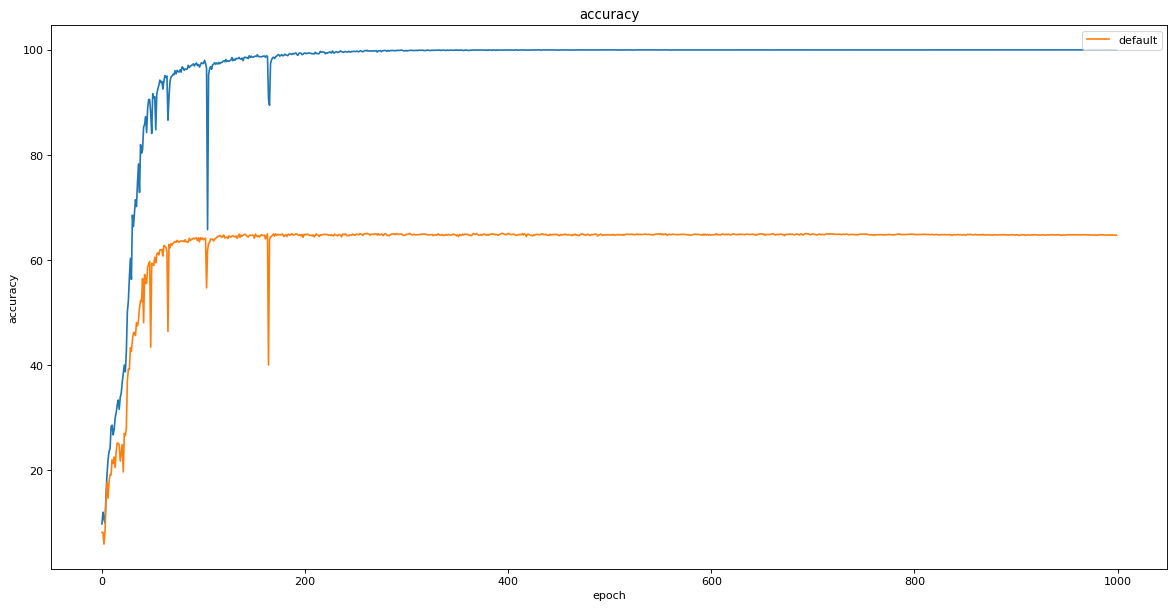

In [9]:
plot_train_test([train_log, test_log], 'accuracy')